## Step 1: Enter your Key

In [4]:
import os
os.environ["GROQ_API_KEY"] = "Enter your key"

## Import necessary Libraries

In [2]:
!pip install requests beautifulsoup4 groq pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 5.0 MB/s eta 0:00:00


## This code takes company  and Person name as input and create a Json with all details

In [7]:
import os
import re
import json
import requests
from bs4 import BeautifulSoup
from groq import Groq

# -----------------------------
# Config
# -----------------------------
BASE_URL = "https://find-and-update.company-information.service.gov.uk"
HEADERS = {"User-Agent": "Mozilla/5.0"}

# Set Groq API key
GROQ_API_KEY = os.getenv("GROQ_API_KEY")  # or set manually
client = Groq(api_key=GROQ_API_KEY)

# -----------------------------
# Step 1: Search entity (company/person)
# -----------------------------
def search_entity(query):
    url = f"{BASE_URL}/search?q={query.replace(' ', '+')}"
    r = requests.get(url, headers=HEADERS, timeout=15)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    results = []
    for a in soup.select("a[href^='/company/']"):
        company_number = re.search(r"/company/(\d+)", a["href"]).group(1)
        title = a.get_text(strip=True)
        results.append({"type": "company", "title": title, "id": company_number})

    for a in soup.select("a[href^='/officers/']"):
        officer_id = re.search(r"/officers/([A-Za-z0-9]+)", a["href"]).group(1)
        title = a.get_text(strip=True)
        results.append({"type": "person", "title": title, "id": officer_id})

    return results

# -----------------------------
# Step 2: Scrape text from URL
# -----------------------------
def scrape_url(url):
    try:
        r = requests.get(url, headers=HEADERS, timeout=15)
        r.raise_for_status()
    except Exception as e:
        return [f"⚠️ Error fetching {url}: {str(e)}"]

    soup = BeautifulSoup(r.text, "html.parser")
    snippets = []

    for tag in soup.find_all(["h1","h2","h3","p","li","dt","dd","span","strong"]):
        text = tag.get_text(strip=True)
        if text and len(text.split()) > 1:
            snippets.append(text)

    return snippets

# -----------------------------
# Step 3: Analyze with Groq
# -----------------------------
def analyze_with_groq(target, entity_type, urls, snippets):
    system_prompt = f"""
You are an expert investigator AI. You are given text snippets scraped from the UK Companies House public site.

Your task:
- If the entity is a COMPANY, return:
  {{
    "name_detected": "",
    "registered_office_address": "",
    "company_status": "",
    "company_type": "",
    "incorporation_date": "",
    "accounts_next": "",
    "accounts_last": "",
    "confirmation_statement_next": "",
    "confirmation_statement_last": "",
    "nature_of_business_sic": "",
    "people_associated": [
        {{"full_name": "", "role": "", "status": "", "appointment_date": "", "resignation_date": "", "correspondence_address": ""}}
    ]
  }}

- If the entity is a PERSON, return:
  {{
    "full_name": "",
    "person_id": "{target}",
    "associated_companies": [
        {{"company_name": "", "company_number": "", "role": "", "status": "", "appointment_date": "", "resignation_date": ""}}
    ]
  }}

Rules:
- Only extract what is explicitly present in snippets.
- Missing info → return empty string.
- Output valid JSON only.
"""

    joined = "\n".join(snippets)
    user_msg = f"Entity type: {entity_type}\nTarget: {target}\nURLs: {urls}\nSnippets:\n{joined}"

    resp = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[
            {"role": "system", "content": system_prompt.strip()},
            {"role": "user", "content": user_msg},
        ],
        temperature=0,
        max_tokens=800,
    )

    return resp.choices[0].message.content.strip()

# -----------------------------
# Step 4: Investigation pipeline (store JSON)
# -----------------------------
def investigate_and_store(query, output_file="investigation_results.json",max_results=10):
    results = search_entity(query)
    if not results:
        print("❌ No results found.")
        return None

    all_data = []

    # Limit to first `max_results` entries
    #results = results[:max_results]


    for r in results:
        entity_type = r["type"]
        entity_id = r["id"]
        print(f"\n🔍 Found {entity_type.upper()}: {r['title']}")

        urls = []
        snippets = []

        if entity_type == "company":
            urls = [
                f"{BASE_URL}/company/{entity_id}",
                f"{BASE_URL}/company/{entity_id}/officers"
            ]
        else:  # person
            urls = [f"{BASE_URL}/officers/{entity_id}"]

        for u in urls:
            snippets.extend(scrape_url(u))

        analysis = analyze_with_groq(entity_id, entity_type, urls, snippets)
        print("\n📊 AI Extracted JSON:")
        print(analysis)

        # Parse JSON safely and store in all_data
        try:
            parsed = json.loads(analysis)
            all_data.append(parsed)
        except Exception as e:
            print(f"⚠️ Failed to parse JSON for {r['title']}: {e}")
            all_data.append({"entity": r['title'], "raw_response": analysis})

    # Save all results to JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(all_data, f, ensure_ascii=False, indent=4)

    print(f"\n✅ All investigation results saved to {output_file}")
    return all_data


if __name__ == "__main__":
    query = input("Enter Company or Person Name: ").strip()
    data = investigate_and_store(query)



Enter Company or Person Name: 79th Group

🔍 Found COMPANY: GRUDGE MATCH MANAGEMENT LTD

📊 AI Extracted JSON:
Here's the extracted JSON data:

```json
{
    "name_detected": "GRUDGE MATCH MANAGEMENT LTD",
    "registered_office_address": "Flat 1 Elsworth Court, 3 Cottonham Close, London, England, N12 9HN",
    "company_status": "",
    "company_type": "Private limited Company",
    "incorporation_date": "13 December 2018",
    "accounts_next": "5 April 2025",
    "accounts_last": "5 April 2024",
    "confirmation_statement_next": "22 March 2026",
    "confirmation_statement_last": "22 March 2025",
    "nature_of_business_sic": "70229 - Management consultancy activities other than financial management",
    "people_associated": [
        {
            "full_name": "ROBERTS, Kenneth",
            "role": "",
            "status": "",
            "appointment_date": "13 December 2018",
            "resignation_date": "",
            "correspondence_address": "Flat 1 Elsworth Court, 3 Cotto

NameError: name 'pd' is not defined

## This code converts json into excel

In [9]:
import pandas as pd
def save_results_to_excel(all_data, output_file="investigation_results.xlsx"):
    rows = []

    for entry in all_data:
        # COMPANY type with associated people
        if "people_associated" in entry:
            company_name = entry.get("name_detected", "")
            company_number = entry.get("company_number", "")
            company_status = entry.get("company_status", "")
            for person in entry["people_associated"]:
                rows.append({
                    "company_name": company_name,
                    "company_number": company_number,
                    "company_status": company_status,
                    "person_name": person.get("full_name", ""),
                    "role": person.get("role", ""),
                    "appointment_date": person.get("appointment_date", ""),
                    "resignation_date": person.get("resignation_date", ""),
                    "correspondence_address": person.get("correspondence_address", "")
                })

        # PERSON type with associated companies
        elif "associated_companies" in entry:
            person_name = entry.get("full_name", "")
            person_id = entry.get("person_id", "")
            for comp in entry["associated_companies"]:
                rows.append({
                    "company_name": comp.get("company_name", ""),
                    "company_number": comp.get("company_number", ""),
                    "company_status": comp.get("status", ""),
                    "person_name": person_name,
                    "role": comp.get("role", ""),
                    "appointment_date": comp.get("appointment_date", ""),
                    "resignation_date": comp.get("resignation_date", ""),
                    "correspondence_address": ""
                })

    # Convert to DataFrame and save to Excel
    df = pd.DataFrame(rows)
    df.to_excel(output_file, index=False)
    print(f"\n✅ All investigation results saved to {output_file}")


if __name__ == "__main__":
    save_results_to_excel(data)



✅ All investigation results saved to investigation_results.xlsx


# Visualize the data

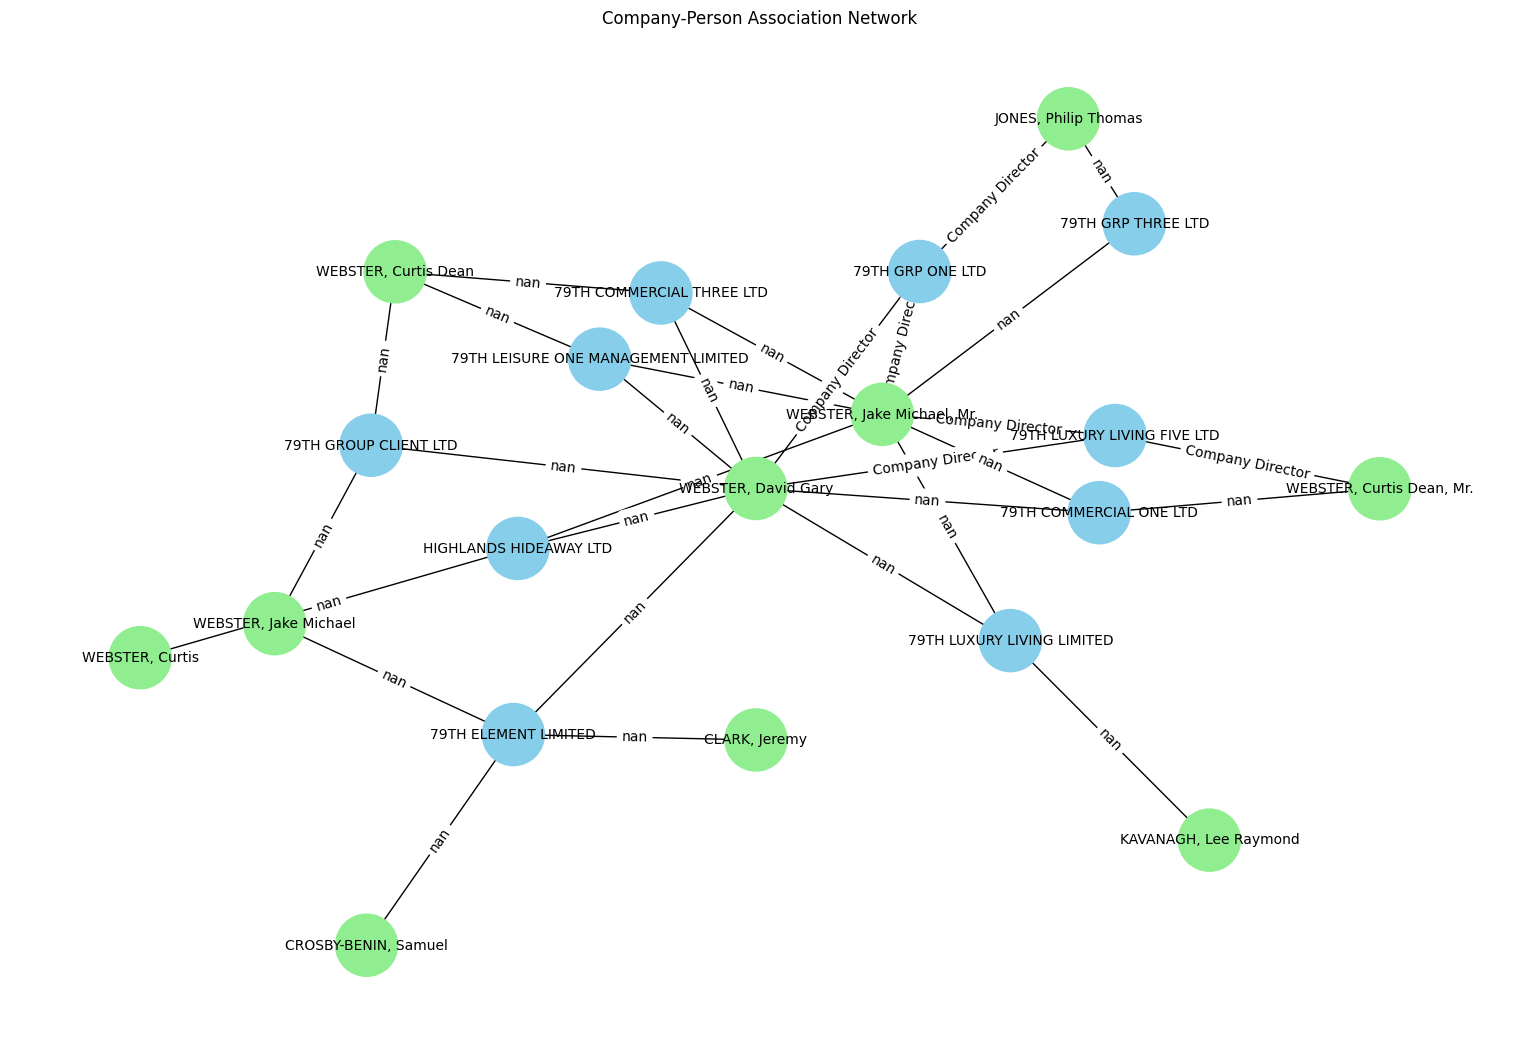

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load Excel data
df = pd.read_excel("investigation_results.xlsx")

# Create graph
G = nx.Graph()

# Add nodes and edges
for idx, row in df.iterrows():
    company = row['company_name']
    person = row['person_name']
    role = row['role']

    # Add nodes
    G.add_node(company, type='company')
    G.add_node(person, type='person')

    # Add edge with role as label
    G.add_edge(company, person, label=role)

# Draw graph
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(15, 10))

# Node colors
colors = ['skyblue' if G.nodes[n]['type']=='company' else 'lightgreen' for n in G.nodes()]

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

plt.title("Company-Person Association Network")
plt.show()


## Visualize in more interactive way

In [11]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

# Load your Excel file
df = pd.read_excel("investigation_results.xlsx")

# Initialize graph
G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    company = row['company_name']
    person = row['person_name']

    # Add nodes
    G.add_node(company, type='company')
    G.add_node(person, type='person')

    # Add edge with role info
    G.add_edge(company, person, role=row.get('role', ''), appointment=row.get('appointment_date', ''))

# Create positions using spring layout
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Create edges trace
edge_x, edge_y, edge_text = [], [], []
for u, v, d in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_text.append(f"{d.get('role', '')}, {d.get('appointment', '')}")

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='text',
    text=edge_text,
    mode='lines'
)

# Create nodes trace
node_x, node_y, node_text, node_color = [], [], [], []
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_color.append('skyblue' if data['type'] == 'company' else 'lightgreen')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=20, color=node_color, line_width=2),
    text=node_text,
    hoverinfo='text'
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Company-Person Relationships',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()
